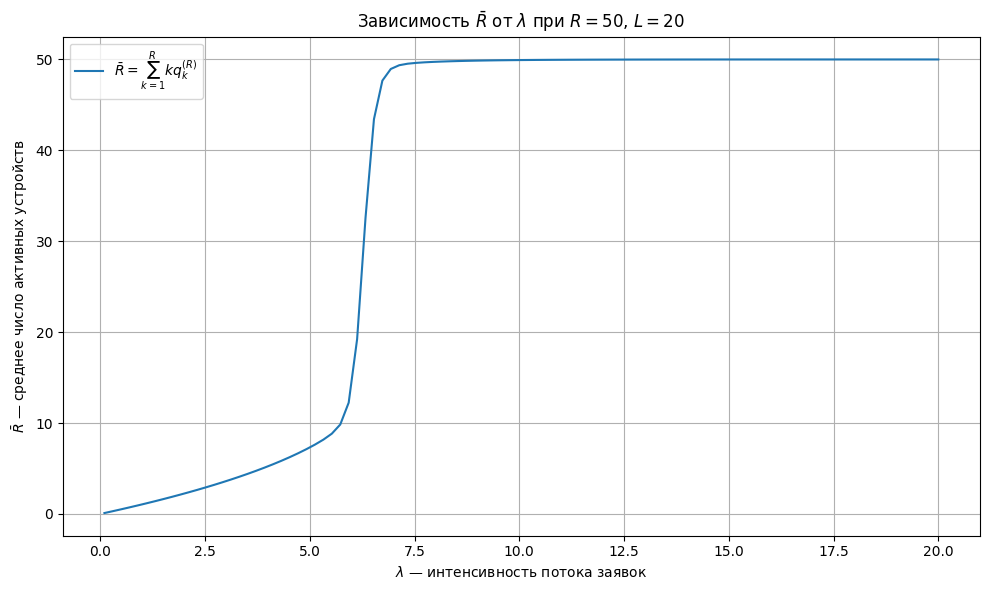

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import comb
from scipy.linalg import solve

# Параметры модели
R = 50          # Максимальное количество устройств в системе
L = 20          # Число доступных преамбул
lambdas = np.linspace(0.1, 20, 100)  # Диапазон значений λ

def compute_beta_tilde(i, L):
    """Вычисление приближенных вероятностей β̃_k(i) для каждого k"""
    m = min(i, L)
    p = (i * (1 - 1/L)**(i - 1)) / m if m > 0 else 0
    betas = [comb(m, k) * (p**k) * ((1 - p)**(m - k)) for k in range(m + 1)]
    return betas

def build_transition_matrix(R, L, lam):
    """Формирование матрицы переходных вероятностей P^(R)"""
    P = np.zeros((R + 1, R + 1))
    alpha = poisson.pmf(np.arange(0, 3*R), mu=lam)  # Усечённое распределение Пуассона

    for i in range(R + 1):
        beta_tilde = compute_beta_tilde(i, L)
        for j in range(R):  # Для состояний j < R
            pij = 0
            for k in range(max(0, i - j), min(i, L) + 1):
                a = j - i + k
                if 0 <= a < len(alpha):
                    pij += beta_tilde[k] * alpha[a]
            P[i, j] = pij
        # Для j = R (переполнение)
        P[i, R] = 1 - np.sum(P[i, :R])
    return P

def compute_stationary_distribution(P):
    """Решение системы уравнений для нахождения q^(R)"""
    A = P.T - np.eye(P.shape[0])
    A[-1, :] = 1  # Условие нормировки
    b = np.zeros(P.shape[0])
    b[-1] = 1
    q = solve(A, b)
    return q

# Вычисление среднего числа устройств в RA-фазе для разных λ
mean_R_values = []

for lam in lambdas:
    P = build_transition_matrix(R, L, lam)
    q = compute_stationary_distribution(P)
    mean_R = sum(k * q[k] for k in range(1, R + 1))
    mean_R_values.append(mean_R)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(lambdas, mean_R_values, label=r"$\bar{R} = \sum_{k=1}^{R} k q_k^{(R)}$")
plt.xlabel(r"$\lambda$ — интенсивность потока заявок")
plt.ylabel(r"$\bar{R}$ — среднее число активных устройств")
plt.title(r"Зависимость $\bar{R}$ от $\lambda$ при $R=50$, $L=20$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
